<a href="https://colab.research.google.com/github/tgmeiner/exploring-generative/blob/main/221221_image2pc_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Point-E: Image-3D Modelling

---



Questions: 

*   Can generated point clouds be easiliy converted to closed and clean meshes? step? T-splines?
*   Can generation of mesh models be parrallelized via generated prompts to create large training sets of unique models? 


### **Set up**

In [ ]:
#check gpu

!nvidia-smi

Wed Dec 21 16:31:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#install data viz package
!pip install plotly -q

In [ ]:
#clone point-e

!git clone http://github.com/openai/point-e

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 57 (delta 6), reused 56 (delta 6), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [ ]:
#install the model
%cd point-e
!pip install -e . 

/content/point-e
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/point-e
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-sd5x6aaw/clip_2297559ed91747a58eb7c24ebf69dad3
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-install-sd5x6aaw/clip_2297559ed91747a58eb7c24ebf69dad3
     |████████████████████████████████| 88 kB 6.4 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=04f7ad3893dcf12e2de28a963231401efa3c423f9fe8e1957b5bbb60f08729d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-3j195hcg/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=96f3b726a1ba500b9d1733c6cf90fd706c77369067b59bf405f549a556d9dbde
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddf

In [ ]:
#import required pything imaging libpytorch libraries for creating point clouds

from PIL import Image

import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.models.configs import MODEL_CONFIGS, model_from_config

from point_e.diffusion.sampler import PointCloudSampler

from point_e.util.plotting import plot_point_cloud
from point_e.models.download import load_checkpoint



In [ ]:
#initialize models 


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|███████████████████████████████████████| 890M/890M [00:17<00:00, 51.9MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/161M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [ ]:
#create point cloud sampler

timos_sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LICENSE        point_e		 point_e_model_cache  setup.py
model-card.md  point_e.egg-info  README.md	      timos_prompt_images


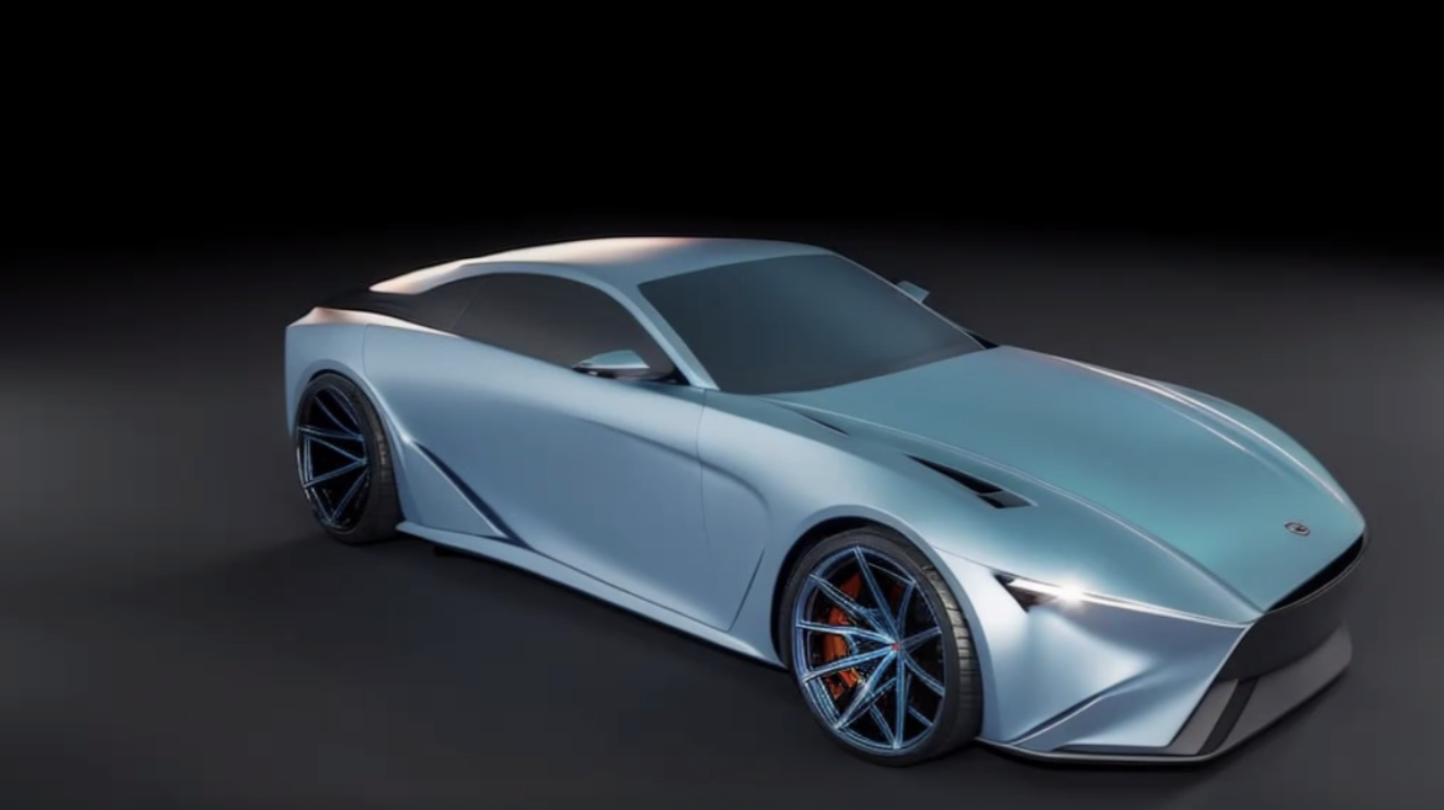

In [ ]:
img = Image.open('/content/point-e/timos_prompt_images/221221_BlankAI_SD_output.png')
display(img)

In [ ]:

# Produce a sample from the model.
samples = None
for x in tqdm(timos_sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

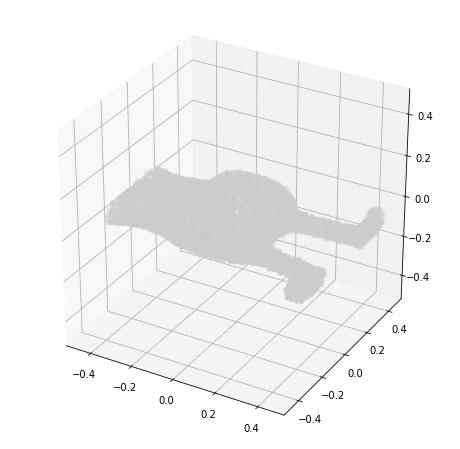

In [ ]:
#output from sample to a point cloud, and plot it in 2D

point_cloud = timos_sampler.output_to_point_clouds(samples)[0]

fig = plot_point_cloud(point_cloud, grid_size=1, fixed_bounds= ((-0.5, -0.5, -0.5),(0.5, 0.5, 0.5)))

In [ ]:
#visualize as 3D via plotly

import plotly.graph_objects as go


In [ ]:
# create scatter 3D plot + add colours
fig_plotly = go.Figure(
        data=[
            go.Scatter3d(
                x=point_cloud.coords[:,0], y=point_cloud.coords[:,1], z=point_cloud.coords[:,2], 
                mode='markers',
                marker=dict(
                  size=2,
                  color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(point_cloud.channels["R"], point_cloud.channels["G"], point_cloud.channels["B"])],
              )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        ),
    )

#visualize with google colab renderer
fig_plotly.show(renderer="colab")